In [ ]:
!pip install datasets
!pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import kagglehub
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

### Dataset

Dataset yang dipakai berasal dari:
1. https://www.kaggle.com/datasets/danielfesalbon/gosu-ai-english-dota-chat/data
2. https://huggingface.co/datasets/dffesalbon/dota-2-toxic-chat-data
<br> <br>
Dataset berisikan text chat dari game dota 2, yang memiliki label non-toxic, somewhat toxic, dan toxic.

In [ ]:
ds = load_dataset("dffesalbon/dota-2-toxic-chat-data")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/43.3k [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/5.03k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1722 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/192 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/638 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['message', 'target'],
        num_rows: 1722
    })
    validation: Dataset({
        features: ['message', 'target'],
        num_rows: 192
    })
    test: Dataset({
        features: ['message', 'target'],
        num_rows: 638
    })
})

In [ ]:
df_train = ds["train"].to_pandas()
df_validation = ds["validation"].to_pandas()
df_test = ds["test"].to_pandas()

df_1 = pd.concat([df_train, df_validation, df_test], ignore_index=True)

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2552 entries, 0 to 2551
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  2552 non-null   object
 1   target   2552 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 40.0+ KB


In [ ]:
path = kagglehub.dataset_download("danielfesalbon/gosu-ai-english-dota-chat")

print("Path to dataset files:", path)

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df_2 = pd.read_csv(os.path.join(path, csv_file))

print(df_2.head())

100%|██████████| 68.3k/68.3k [00:00<00:00, 57.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/danielfesalbon/gosu-ai-english-dota-chat/versions/1
   Unnamed: 0  match        time  slot                     text  target
0           2      2  2263.90490     4            COMMEND ME TY       0
1           7      6   242.54080     8                sorry nex       0
2          11      6  2279.16280     2   what is the best soup?       0
3          18      9  1011.11982     4  man that silence on axe       0
4          21      9  1769.30452     3     not coming into play       0


In [ ]:
df_2 = df_2[["text", "target"]].rename(columns={"text": "message"})
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3267 entries, 0 to 3266
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  3267 non-null   object
 1   target   3267 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.2+ KB


#### Combined dataset

In [ ]:
df = pd.concat([df_1, df_2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819 entries, 0 to 5818
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  5819 non-null   object
 1   target   5819 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.1+ KB


#### Save to CSV File

In [ ]:
df.to_csv("dota_chat.csv", index=False)

### Checkpoint

In [ ]:
df = pd.read_csv("dota_chat.csv")
df.tail()

,message,target
5814,"wt?f?asfU JGOFIDLK,YH",1
5815,you must really suck,2
5816,YOU HAVE IDIOT PLAYER,2
5817,SUPER IDIOT,2
5818,fuck off weab,2


### Data preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819 entries, 0 to 5818
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  5819 non-null   object
 1   target   5819 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.1+ KB


In [ ]:
df_cleaned = df.copy()

In [ ]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df_cleaned["message"] = df_cleaned["message"].astype(str).apply(clean_text)

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

df_cleaned["message"] = df_cleaned["message"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
lemmatizer = WordNetLemmatizer()
df_cleaned["message"] = df_cleaned["message"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

#### Wordcloud for uncleaned dataset

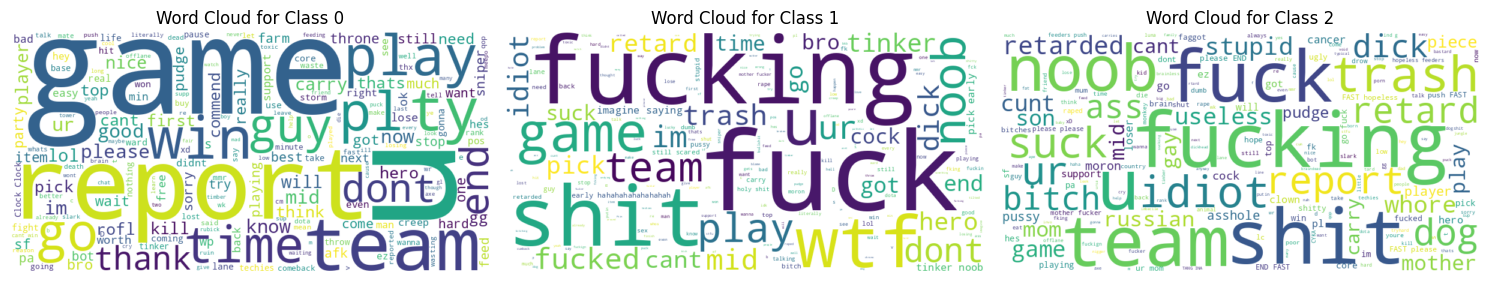

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to generate a word cloud
def plot_wordcloud(df, class_label, ax):
    text = " ".join(df[df["target"] == class_label]["message"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Word Cloud for Class {class_label}")
    ax.axis("off")

# Create subplots for each class
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, class_label in enumerate([0, 1, 2]):
    plot_wordcloud(df, class_label, axes[i])

plt.tight_layout()
plt.show()

#### Wordcloud for cleaned dataset

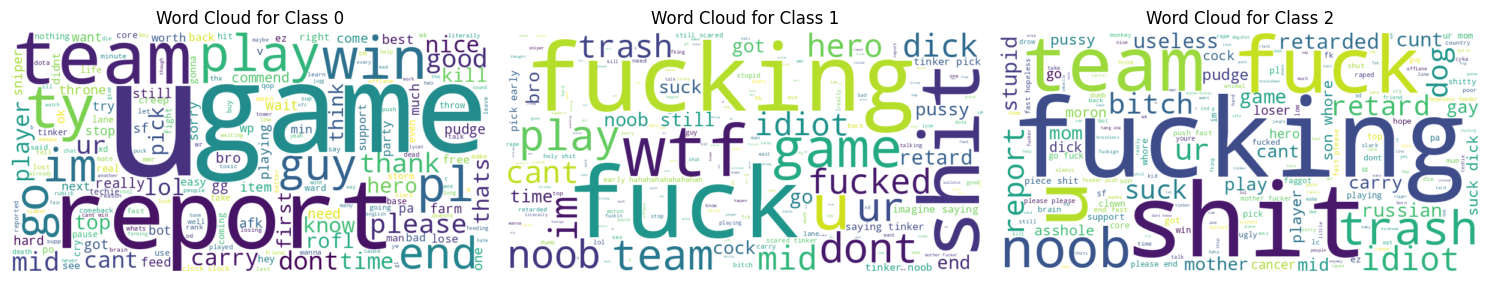

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to generate a word cloud
def plot_wordcloud(df, class_label, ax):
    text = " ".join(df_cleaned[df_cleaned["target"] == class_label]["message"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Word Cloud for Class {class_label}")
    ax.axis("off")

# Create subplots for each class
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, class_label in enumerate([0, 1, 2]):
    plot_wordcloud(df_cleaned, class_label, axes[i])

plt.tight_layout()
plt.show()

#### Target value distribution

In [ ]:
df['message'].duplicated().sum()

350

In [ ]:
df['target'].value_counts()

,count
target,
0,3192
2,1636
1,991


### Modelling

In [ ]:
X = df_cleaned["message"].astype(str)
y = df_cleaned["target"].astype(int)

# Tokenization
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")

# One-hot encode labels (optional)
y_one_hot = to_categorical(y, num_classes=3)

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_one_hot, test_size=0.2, random_state=42)

print("Data preprocessing complete!")

Data preprocessing complete!


#### LSTM

In [ ]:
# Define model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")  # 3 classes -> Softmax activation
])

# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Evaluate model
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5422 - loss: 1.0102 - val_accuracy: 0.5361 - val_loss: 1.0016
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5518 - loss: 0.9925 - val_accuracy: 0.5361 - val_loss: 1.0016
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5452 - loss: 0.9962 - val_accuracy: 0.5361 - val_loss: 1.0068
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5546 - loss: 0.9861 - val_accuracy: 0.5361 - val_loss: 1.0045
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5524 - loss: 0.9903 - val_accuracy: 0.5361 - val_loss: 1.0046
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5468 - loss: 0.9981
Test Accuracy: 0.5361


In [ ]:
# Evaluate model
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# Predict classes for the test set
y_pred_probs = model.predict(X_test)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Get true class labels from one-hot encoded y_test
y_true_classes = np.argmax(y_test, axis=1)

# Generate and print the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true_classes, y_pred_classes)
print(report)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5468 - loss: 0.9981
Test Accuracy: 0.5361
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       624
           1       0.00      0.00      0.00       212
           2       0.00      0.00      0.00       328

    accuracy                           0.54      1164
   macro avg       0.18      0.33      0.23      1164
weighted avg       0.29      0.54      0.37      1164



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### CNN

In [ ]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    Conv1D(64, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")  # Multi-class classification
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5906 - loss: 0.9155 - val_accuracy: 0.7835 - val_loss: 0.5316
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8383 - loss: 0.3854 - val_accuracy: 0.8162 - val_loss: 0.4704
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9208 - loss: 0.2206 - val_accuracy: 0.8187 - val_loss: 0.4831
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9511 - loss: 0.1399 - val_accuracy: 0.8136 - val_loss: 0.5821
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9699 - loss: 0.0966 - val_accuracy: 0.8084 - val_loss: 0.6255
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8184 - loss: 0.5987
Test Accuracy: 0.8084


In [ ]:
# Predict classes for the test set
y_pred_probs = model.predict(X_test)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Get true class labels from one-hot encoded y_test
y_true_classes = np.argmax(y_test, axis=1)

# Generate and print the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true_classes, y_pred_classes)
print(report)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.92       624
           1       0.64      0.60      0.62       212
           2       0.73      0.66      0.69       328

    accuracy                           0.81      1164
   macro avg       0.75      0.74      0.75      1164
weighted avg       0.80      0.81      0.80      1164



#### BERT

In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 833.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# Convert dataframe to Hugging Face dataset format
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(df_train[['message', 'target']])
test_dataset = Dataset.from_pandas(df_test[['message', 'target']])

In [ ]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['message'], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'target' column to 'labels' (Trainer expects this column name)
train_dataset = train_dataset.rename_column("target", "labels")
test_dataset = test_dataset.rename_column("target", "labels")

# Ensure the dataset is formatted properly for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/4655 [00:00<?, ? examples/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

In [ ]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory for models and logs
    evaluation_strategy="epoch",     # evaluation frequency
    learning_rate=2e-5,              # learning rate
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size per device during evaluation
    num_train_epochs=3,              # number of training epochs
    weight_decay=0.01,               # strength of weight decay
)

trainer = Trainer(
    model=model,                         # the model to train
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

# Start training
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ljervino (ljervino-binus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,0.428083
2,0.513400,0.370708
3,0.513400,0.397869


TrainOutput(global_step=873, training_loss=0.41317542776345934, metrics={'train_runtime': 434.4722, 'train_samples_per_second': 32.142, 'train_steps_per_second': 2.009, 'total_flos': 918594719642880.0, 'train_loss': 0.41317542776345934, 'epoch': 3.0})

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import evaluate
from sklearn.metrics import classification_report

# Load accuracy, precision, recall, and F1-score metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Convert logits to predicted class

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

# Reinitialize Trainer with compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Run evaluation
results = trainer.evaluate()
print(results)

# Generate predictions for classification report
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
labels = predictions_output.label_ids

predictions = np.argmax(logits, axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(labels, predictions, target_names=["Class 0", "Class 1", "Class 2"])  # Update class names
print(report)

{'eval_loss': 0.3978693187236786, 'eval_model_preparation_time': 0.0048, 'eval_accuracy': 0.8548109965635738, 'eval_precision': 0.8253043675622195, 'eval_recall': 0.7953745166987228, 'eval_f1': 0.8038930257978137, 'eval_runtime': 7.7345, 'eval_samples_per_second': 150.495, 'eval_steps_per_second': 2.457}
              precision    recall  f1-score   support

     Class 0       0.94      0.95      0.95       624
     Class 1       0.80      0.59      0.68       212
     Class 2       0.73      0.84      0.78       328

    accuracy                           0.85      1164
   macro avg       0.83      0.80      0.80      1164
weighted avg       0.86      0.85      0.85      1164



### Sentence Transformer (untuk 2 skenario)

Sentence Transformers (SBERT) only generates text embeddings—dense vector representations of text. It does not perform classification by itself. The embeddings are then used with a classifier (e.g., Logistic Regression, SVM, or Neural Networks) to make predictions.

Skenario 1:
Class tetap 0,1,2
<br>
Skenario 2:
Class 1 dan 2 digabung

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df_cleaned["target_merged"] = df_cleaned["target"].replace({2: 1})

# Split dataset for both scenarios
X_train, X_test, y_train, y_test = train_test_split(df_cleaned["message"], df_cleaned["target"], test_size=0.2, random_state=42, stratify=df_cleaned["target"])
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(df_cleaned["message"], df_cleaned["target_merged"], test_size=0.2, random_state=42, stratify=df_cleaned["target_merged"])

In [ ]:
# Load SBERT model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Encode text for both original and merged label datasets
X_train_emb = model.encode(X_train.tolist(), convert_to_numpy=True)
X_test_emb = model.encode(X_test.tolist(), convert_to_numpy=True)

X_train_m_emb = model.encode(X_train_m.tolist(), convert_to_numpy=True)
X_test_m_emb = model.encode(X_test_m.tolist(), convert_to_numpy=True)

Train and evaluate using logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_emb, y_train)
y_pred = clf.predict(X_test_emb)

print("=== Original Classes (0,1,2) ===")
print(classification_report(y_test, y_pred))

=== Original Classes (0,1,2) ===
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       639
           1       0.71      0.51      0.59       198
           2       0.71      0.70      0.71       327

    accuracy                           0.80      1164
   macro avg       0.76      0.72      0.73      1164
weighted avg       0.79      0.80      0.79      1164



In [ ]:
clf_m = LogisticRegression(max_iter=1000)
clf_m.fit(X_train_m_emb, y_train_m)
y_pred_m = clf_m.predict(X_test_m_emb)

print("=== Merged Classes (0,1) ===")
print(classification_report(y_test_m, y_pred_m))

=== Merged Classes (0,1) ===
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       639
           1       0.89      0.84      0.87       525

    accuracy                           0.88      1164
   macro avg       0.89      0.88      0.88      1164
weighted avg       0.88      0.88      0.88      1164



### 2 Class classification

In [ ]:
df_cleaned["target"] = df_cleaned["target"].replace({2: 1})

In [ ]:
# Tokenisasi
MAX_VOCAB = 10000
MAX_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df_cleaned["message"])
sequences = tokenizer.texts_to_sequences(df_cleaned["message"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding="post")

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df_cleaned["target"], test_size=0.2, random_state=42)

#### CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import classification_report

# Model CNN
model_cnn = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LENGTH),
    Conv1D(64, 5, activation="relu"),
    MaxPooling1D(2),
    Conv1D(32, 5, activation="relu"),
    MaxPooling1D(2),
    Flatten(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Evaluasi
y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_cnn))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6047 - loss: 0.6545 - val_accuracy: 0.9021 - val_loss: 0.2685
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9174 - loss: 0.2403 - val_accuracy: 0.9124 - val_loss: 0.2371
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9660 - loss: 0.1138 - val_accuracy: 0.9124 - val_loss: 0.2621
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9733 - loss: 0.0888 - val_accuracy: 0.9029 - val_loss: 0.3136
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9829 - loss: 0.0653 - val_accuracy: 0.9046 - val_loss: 0.3208
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       624
           1       0.92      0.87      0.89       540

    accuracy                           0.90      1164
   macro avg       0.91      0.90      0.90      1164
weighted avg       0.91      0.90      0.90      1164



#### LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Model LSTM
model_lstm = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LENGTH),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Evaluasi
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_lstm))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5360 - loss: 0.6905 - val_accuracy: 0.5361 - val_loss: 0.6906
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5582 - loss: 0.6885 - val_accuracy: 0.5361 - val_loss: 0.6906
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5454 - loss: 0.6894 - val_accuracy: 0.5361 - val_loss: 0.6908
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5483 - loss: 0.6896 - val_accuracy: 0.5361 - val_loss: 0.6907
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5505 - loss: 0.6884 - val_accuracy: 0.5361 - val_loss: 0.6920
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       624
           1       0.00      0.00      0.00       540

    accuracy                           0.54      1164
   macro avg       0.27      0.50      0.35      1164
weighted avg       0.29      0.54      0.37      1164



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### BERT

In [ ]:
# !pip install transformers datasets tensorflow

In [ ]:
df["target"] = df["target"].replace({2: 1})

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np

# Load tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenisasi data
def encode_texts(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

# Tokenisasi dataset
encoded_data = encode_texts(df["message"])
input_ids = encoded_data["input_ids"]
attention_masks = encoded_data["attention_mask"]

# Pastikan label bertipe integer
df["target"] = df["target"].astype(int)

# Konversi Tensor menjadi Numpy Array
input_ids_np = input_ids.numpy()

# Split data dengan sklearn
X_train, X_test, y_train, y_test = train_test_split(
    input_ids_np, df["target"], test_size=0.2, random_state=42
)

# Konversi label ke numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Load model BERT dengan 2 kelas (0 = non-toxic, 1 = toxic)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, from_pt=True)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf

optimizer = tf.optimizers.Adam(learning_rate=2e-5)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile ulang model
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
# Training model
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=3,
    batch_size=16
)

Epoch 1/3
291/291 [==============================] - 201s 470ms/step - loss: 0.3928 - accuracy: 0.8105 - val_loss: 0.1817 - val_accuracy: 0.9330
Epoch 2/3
291/291 [==============================] - 142s 488ms/step - loss: 0.1627 - accuracy: 0.9467 - val_loss: 0.1347 - val_accuracy: 0.9493
Epoch 3/3
291/291 [==============================] - 142s 488ms/step - loss: 0.0845 - accuracy: 0.9744 - val_loss: 0.1807 - val_accuracy: 0.9476


In [ ]:
from sklearn.metrics import classification_report

# Prediksi pada data uji
y_pred = model.predict(X_test)
y_pred_labels = tf.argmax(y_pred.logits, axis=1).numpy()  # Konversi logits ke label

# Cetak classification report
print(classification_report(y_test, y_pred_labels, target_names=["Non-Toxic", "Toxic"]))

37/37 [==============================] - 13s 265ms/step
              precision    recall  f1-score   support

   Non-Toxic       0.95      0.95      0.95       624
       Toxic       0.95      0.94      0.94       540

    accuracy                           0.95      1164
   macro avg       0.95      0.95      0.95      1164
weighted avg       0.95      0.95      0.95      1164

